In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations
from scipy.sparse import coo_matrix

from qiskit import transpile, QuantumCircuit
from qiskit.primitives import BackendSampler
from qiskit.quantum_info import hellinger_fidelity, SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.result import sampled_expectation_value
from qiskit_aer import AerSimulator

from cd_coefficients import eval_A, eval_B, eval_C, eval_D, first_order_cd_coeff
from scheduling_function import f, df
from bias_field import eval_hb, gs_rotation_angle
from dcqo import dcqo_circ, bf_dcqo_circ

## Heavy-hex 44Q Ising model

In [2]:
# 1st layer
edges_1 = [(0, 9), (1, 2), (4, 5), (6, 7), (10, 16), (14, 15), (17, 18), (19, 20), (21, 25), (23, 32), (27, 33), (29, 30), (35, 36), (38, 39), (40, 41), (42, 43)]

# 2nd layer
edges_2 = [(2, 3), (4, 10), (5, 6), (8, 11), (9, 12), (13, 14), (15, 16), (18, 22), (24, 25), (26, 27), (28, 29), (30, 31), (33, 39), (34, 43), (36, 37), (41, 42)]

# 3rd layer
edges_3 = [(0, 1), (3, 4), (7, 8), (11, 20), (12, 13), (14, 21), (16, 17), (18, 19), (22, 29), (23, 24), (25, 26), (27, 28), (31, 34), (32, 35), (37, 38), (39, 40)]

num_nodes = 44
num_edges = len(edges_1 + edges_2 + edges_3)
print(num_edges)

48


In [3]:
# Hi
hx = - np.ones(num_nodes)

# Hf
rng = np.random.default_rng(seed=42)
# mean, standard_deviation = 0, 1.0
hz = rng.standard_normal(size=num_nodes)

row = np.array([e[0] for e in edges_1 + edges_2 + edges_3])
col = np.array([e[1] for e in edges_1 + edges_2 + edges_3])
# mean, standard_deviation = 0, 1.0
data = rng.standard_normal(size=num_edges)

J = coo_matrix((data, (row, col)), shape=(num_nodes, num_nodes))
J2 = coo_matrix((data ** 2, (row, col)), shape=(num_nodes, num_nodes))
J4 = coo_matrix((data ** 4, (row, col)), shape=(num_nodes, num_nodes))

In [4]:
pauli_list = []

for i, d in enumerate(hz):
    pauli_list.append(("Z", [i], d))

for i, j, d in zip(row, col, data):
    pauli_list.append(("ZZ", [i, j], d))

# via triples and local Paulis with indices
Hf = SparsePauliOp.from_sparse_list(pauli_list, num_qubits=num_nodes)

## Adiabatic and counterdiabatic terms of Ising model Hamiltonian without bias field
$$H_{ad} = (1 - \lambda) \sum_i h^x_i X_i + \mathcal{O}(\lambda)$$
$$H_{cd} = - 2 \dot{\lambda} \alpha_1 \left[ \sum_i h^z_i Y_i + \sum_{i < j} J_{ij} (Y_i Z_j + Z_i Y_j) \right]$$

## Adiabatic and counterdiabatic terms of Ising model Hamiltonian with bias field
$$H_{ad} = (1 - \lambda) \sum_i (h^x_i X_i + h^b_i Z_i) + \mathcal{O}(\lambda)$$
$$H_{cd} = - 2 \dot{\lambda} \alpha_1 \left[ \sum_i h^z_i Y_i + \sum_{i < j} J_{ij} (Y_i Z_j + Z_i Y_j) \right]$$

In [5]:
# threshold for gate cutoff
threshold = 0.01
shots = 2 ** 13

# MPS simulator
backend = AerSimulator(method="matrix_product_state")
sampler = BackendSampler(backend, options={"shots": shots})

## 1st iteration (without bias field)

In [6]:
hb = np.zeros(num_nodes)

T = 1
dt = 0.1
trotter_steps = [1, 2, 3]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=None)
C = eval_C(hx, hz, J2, hb=None)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

[0.0014769153294477333, 0.022331076294855843, 0.10120449450040796]
[0.058561065202698374, 0.42858717205073044, 1.20408664729688]
[-0.08741181588379157, -0.09109503811853172, -0.10546702780798843]
[0.010237858098913968, 0.07808432955015, 0.2539828798273752]


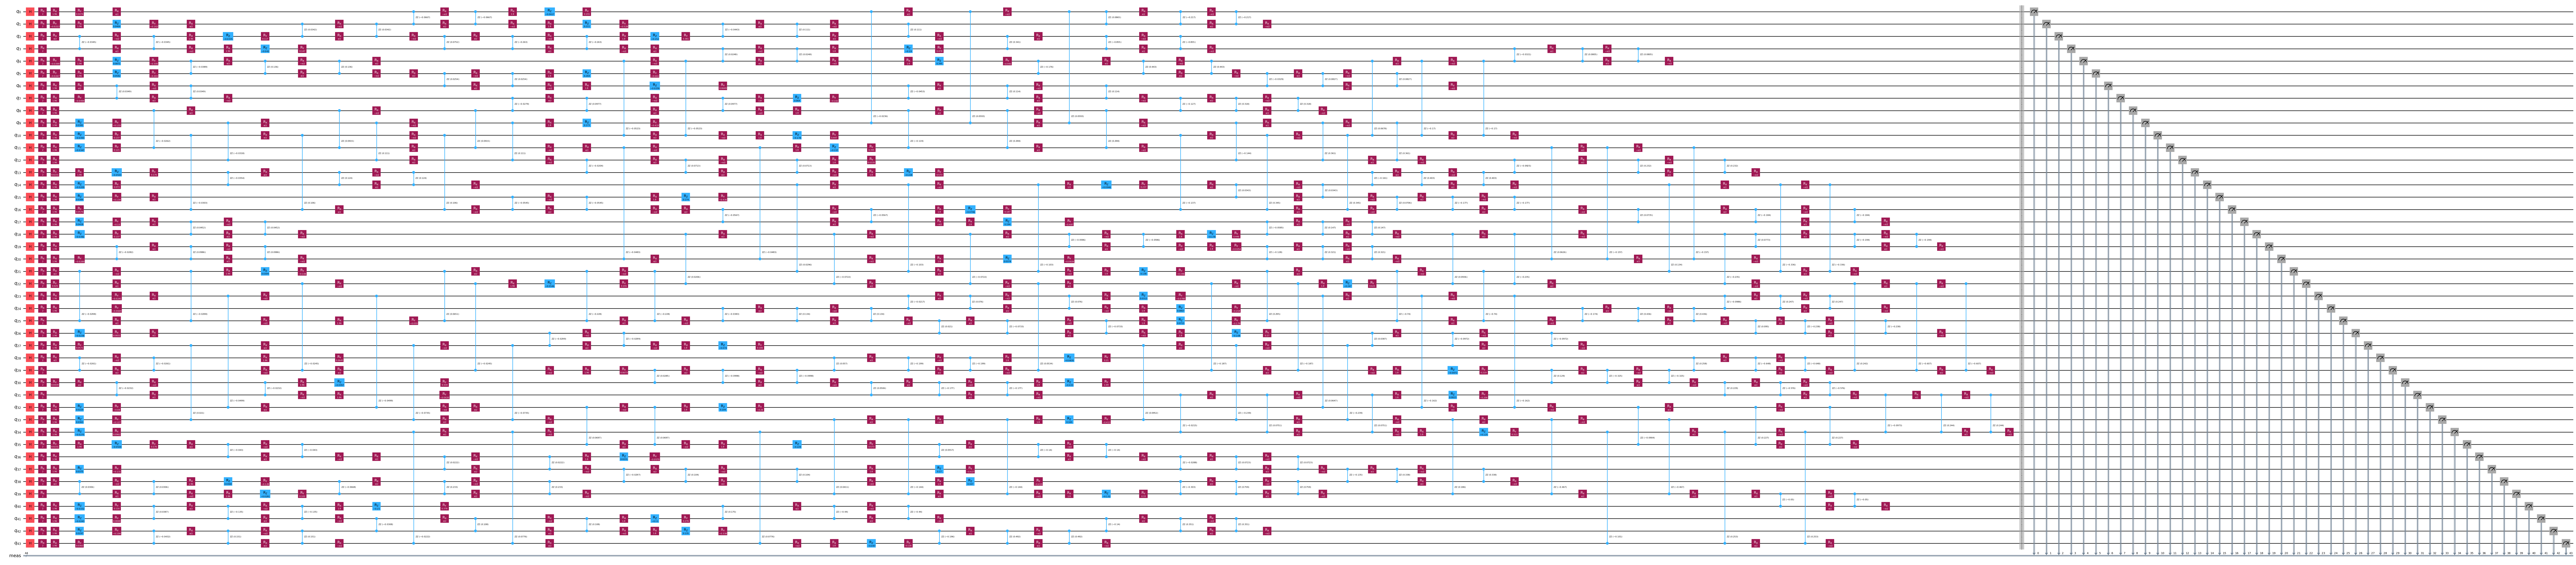

In [7]:
circ = dcqo_circ(num_nodes, hx, hz, row, col, data, y, dy, a1, threshold=threshold)
circ.draw("mpl", fold=-1)

In [9]:
# circ = dcqo_circ(num_nodes, hx, hz, row, col, data, y, dy, a1, threshold=threshold)
job = sampler.run(circuits=[circ], shots=shots)
job_result = job.result()
pdist_0 = job_result.quasi_dists[0].binary_probabilities()
# print(pdist_0)

In [10]:
objective_0 = []
for k, p in pdist_0.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_0.append(v)

print(min(objective_0))

-39.46740114781878


## 2nd iteration (with bias field)

In [11]:
hb = eval_hb(num_nodes, pdist_0)
# hb = - eval_hb(num_nodes, pdist_0)
phi = [gs_rotation_angle(hxi, hbi) for hxi, hbi in zip(hx, hb)]

T = 1
dt = 0.1
trotter_steps = [1, 2, 3]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=hb)
C = eval_C(hx, hz, J2, hb=hb)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

[0.0014769153294477333, 0.022331076294855843, 0.10120449450040796]
[0.058561065202698374, 0.42858717205073044, 1.20408664729688]
[-0.08027492637875545, -0.08473172172767343, -0.1036973995989177]
[0.00940197039561622, 0.07262985799650598, 0.2497213084329313]


In [12]:
circ = bf_dcqo_circ(num_nodes, phi, hx, hb, hz, row, col, data, y, dy, a1, threshold=threshold)
job = sampler.run(circuits=[circ])
job_result = job.result()
pdist_1 = job_result.quasi_dists[0].binary_probabilities()
# print(pdist_1)

In [13]:
objective_1 = []
for k, p in pdist_1.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_1.append(v)

print(min(objective_1))

-32.75179490650501


## 3rd iteration

In [14]:
hb = eval_hb(num_nodes, pdist_1)
# hb = - eval_hb(num_nodes, pdist_1)
phi = [gs_rotation_angle(hxi, hbi) for hxi, hbi in zip(hx, hb)]

T = 1
dt = 0.1
trotter_steps = [1, 2, 3]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=hb)
C = eval_C(hx, hz, J2, hb=hb)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

[0.0014769153294477333, 0.022331076294855843, 0.10120449450040796]
[0.058561065202698374, 0.42858717205073044, 1.20408664729688]
[-0.08608692973147389, -0.0896865533010755, -0.1037327167188643]
[0.010082684610209912, 0.07687701250057011, 0.24980635817802868]


In [15]:
circ = bf_dcqo_circ(num_nodes, phi, hx, hb, hz, row, col, data, y, dy, a1, threshold=threshold)
job = sampler.run(circuits=[circ])
job_result = job.result()
pdist_2 = job_result.quasi_dists[0].binary_probabilities()
# print(pdist_2)

In [16]:
objective_2 = []
for k, p in pdist_2.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_2.append(v)

print(min(objective_2))

-41.8245272880977


## 4th iteration

In [17]:
hb = eval_hb(num_nodes, pdist_2)
# hb = - eval_hb(num_nodes, pdist_2)
phi = [gs_rotation_angle(hxi, hbi) for hxi, hbi in zip(hx, hb)]

T = 1
dt = 0.1
trotter_steps = [1, 2, 3]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=hb)
C = eval_C(hx, hz, J2, hb=hb)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

[0.0014769153294477333, 0.022331076294855843, 0.10120449450040796]
[0.058561065202698374, 0.42858717205073044, 1.20408664729688]
[-0.07652877591178718, -0.08082297642554327, -0.09923837745005969]
[0.008963213272105724, 0.0692793818058929, 0.23898321037404935]


In [18]:
circ = bf_dcqo_circ(num_nodes, phi, hx, hb, hz, row, col, data, y, dy, a1, threshold=threshold)
job = sampler.run(circuits=[circ])
job_result = job.result()
pdist_3 = job_result.quasi_dists[0].binary_probabilities()
# print(pdist_3)

In [19]:
objective_3 = []
for k, p in pdist_3.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_3.append(v)

print(min(objective_3))

-33.2936505076711


## 5th iteration

In [20]:
hb = eval_hb(num_nodes, pdist_3)
# hb = - eval_hb(num_nodes, pdist_3)
phi = [gs_rotation_angle(hxi, hbi) for hxi, hbi in zip(hx, hb)]

T = 1
dt = 0.1
trotter_steps = [1, 2, 3]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=hb)
C = eval_C(hx, hz, J2, hb=hb)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

[0.0014769153294477333, 0.022331076294855843, 0.10120449450040796]
[0.058561065202698374, 0.42858717205073044, 1.20408664729688]
[-0.0848690705102905, -0.08849074130142347, -0.10272115350511153]
[0.009940046343691056, 0.07585199313409971, 0.24737033866087582]


In [21]:
circ = bf_dcqo_circ(num_nodes, phi, hx, hb, hz, row, col, data, y, dy, a1, threshold=threshold)
job = sampler.run(circuits=[circ])
job_result = job.result()
pdist_4 = job_result.quasi_dists[0].binary_probabilities()
# print(pdist_4)

In [22]:
objective_4 = []
for k, p in pdist_4.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_4.append(v)

print(min(objective_4))

-41.8245272880977


## 6th iteration

In [23]:
hb = eval_hb(num_nodes, pdist_4)
phi = [gs_rotation_angle(hxi, hbi) for hxi, hbi in zip(hx, hb)]

T = 1
dt = 0.1
trotter_steps = [1, 2, 3]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=hb)
C = eval_C(hx, hz, J2, hb=hb)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

[0.0014769153294477333, 0.022331076294855843, 0.10120449450040796]
[0.058561065202698374, 0.42858717205073044, 1.20408664729688]
[-0.07600817520492409, -0.08020994984991825, -0.0981567933883054]
[0.008902239408227363, 0.06875391115301474, 0.2363785685206744]


In [24]:
circ = bf_dcqo_circ(num_nodes, phi, hx, hb, hz, row, col, data, y, dy, a1, threshold=threshold)
job = sampler.run(circuits=[circ])
job_result = job.result()
pdist_5 = job_result.quasi_dists[0].binary_probabilities()

In [25]:
objective_5 = []
for k, p in pdist_5.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_5.append(v)

print(min(objective_5))

-31.455434111144154


## 7th iteration

In [26]:
hb = eval_hb(num_nodes, pdist_5)
phi = [gs_rotation_angle(hxi, hbi) for hxi, hbi in zip(hx, hb)]

T = 1
dt = 0.1
trotter_steps = [1, 2, 3]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=hb)
C = eval_C(hx, hz, J2, hb=hb)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

[0.0014769153294477333, 0.022331076294855843, 0.10120449450040796]
[0.058561065202698374, 0.42858717205073044, 1.20408664729688]
[-0.08380245357279537, -0.08738061967286344, -0.10146400574372794]
[0.009815121895645146, 0.07490042535526592, 0.24434290899455352]


In [27]:
circ = bf_dcqo_circ(num_nodes, phi, hx, hb, hz, row, col, data, y, dy, a1, threshold=threshold)
job = sampler.run(circuits=[circ])
job_result = job.result()
pdist_6 = job_result.quasi_dists[0].binary_probabilities()

In [28]:
objective_6 = []
for k, p in pdist_6.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_6.append(v)

print(min(objective_6))

-41.8245272880977


## 8th iteration

In [29]:
hb = eval_hb(num_nodes, pdist_6)
phi = [gs_rotation_angle(hxi, hbi) for hxi, hbi in zip(hx, hb)]

T = 1
dt = 0.1
trotter_steps = [1, 2, 3]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=hb)
C = eval_C(hx, hz, J2, hb=hb)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

[0.0014769153294477333, 0.022331076294855843, 0.10120449450040796]
[0.058561065202698374, 0.42858717205073044, 1.20408664729688]
[-0.07504867390977715, -0.07923020282080136, -0.09715419057686427]
[0.008789860572413016, 0.06791409713594612, 0.23396412720507728]


In [30]:
circ = bf_dcqo_circ(num_nodes, phi, hx, hb, hz, row, col, data, y, dy, a1, threshold=threshold)
job = sampler.run(circuits=[circ])
job_result = job.result()
pdist_7 = job_result.quasi_dists[0].binary_probabilities()

In [31]:
objective_7 = []
for k, p in pdist_7.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_7.append(v)

print(min(objective_7))

-33.85841078052193


## 9th iteration

In [32]:
hb = eval_hb(num_nodes, pdist_7)
phi = [gs_rotation_angle(hxi, hbi) for hxi, hbi in zip(hx, hb)]

T = 1
dt = 0.1
trotter_steps = [1, 2, 3]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=hb)
C = eval_C(hx, hz, J2, hb=hb)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

[0.0014769153294477333, 0.022331076294855843, 0.10120449450040796]
[0.058561065202698374, 0.42858717205073044, 1.20408664729688]
[-0.08368715288878925, -0.08733705814343676, -0.1017828670653773]
[0.00980161763389715, 0.07486308552985156, 0.24511078231402839]


In [33]:
circ = bf_dcqo_circ(num_nodes, phi, hx, hb, hz, row, col, data, y, dy, a1, threshold=threshold)
job = sampler.run(circuits=[circ])
job_result = job.result()
pdist_8 = job_result.quasi_dists[0].binary_probabilities()

In [34]:
objective_8 = []
for k, p in pdist_8.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_8.append(v)

print(min(objective_8))

-41.812827773214956


## 10th iteration

In [35]:
hb = eval_hb(num_nodes, pdist_8)
phi = [gs_rotation_angle(hxi, hbi) for hxi, hbi in zip(hx, hb)]

T = 1
dt = 0.1
trotter_steps = [1, 2, 3]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=hb)
C = eval_C(hx, hz, J2, hb=hb)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

[0.0014769153294477333, 0.022331076294855843, 0.10120449450040796]
[0.058561065202698374, 0.42858717205073044, 1.20408664729688]
[-0.07590880294302399, -0.08008969421201928, -0.09792932465537825]
[0.00889060071721042, 0.0686508311054742, 0.23583078439268418]


In [36]:
circ = bf_dcqo_circ(num_nodes, phi, hx, hb, hz, row, col, data, y, dy, a1, threshold=threshold)
job = sampler.run(circuits=[circ])
job_result = job.result()
pdist_9 = job_result.quasi_dists[0].binary_probabilities()

In [37]:
objective_9 = []
for k, p in pdist_9.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_9.append(v)

print(min(objective_9))

-32.86105675578936


## 11th iteration

In [38]:
hb = eval_hb(num_nodes, pdist_9)
phi = [gs_rotation_angle(hxi, hbi) for hxi, hbi in zip(hx, hb)]

T = 1
dt = 0.1
trotter_steps = [1, 2, 3]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=hb)
C = eval_C(hx, hz, J2, hb=hb)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

[0.0014769153294477333, 0.022331076294855843, 0.10120449450040796]
[0.058561065202698374, 0.42858717205073044, 1.20408664729688]
[-0.0834067242429673, -0.08698349155187184, -0.1010849180031495]
[0.009768773233471783, 0.0745600173186307, 0.24343000002138465]


In [39]:
circ = bf_dcqo_circ(num_nodes, phi, hx, hb, hz, row, col, data, y, dy, a1, threshold=threshold)
job = sampler.run(circuits=[circ])
job_result = job.result()
pdist_10 = job_result.quasi_dists[0].binary_probabilities()

In [40]:
objective_10 = []
for k, p in pdist_10.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_10.append(v)

print(min(objective_10))

-41.922010949025484


## 12th iteration

In [41]:
hb = eval_hb(num_nodes, pdist_10)
phi = [gs_rotation_angle(hxi, hbi) for hxi, hbi in zip(hx, hb)]

T = 1
dt = 0.1
trotter_steps = [1, 2, 3]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=hb)
C = eval_C(hx, hz, J2, hb=hb)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

[0.0014769153294477333, 0.022331076294855843, 0.10120449450040796]
[0.058561065202698374, 0.42858717205073044, 1.20408664729688]
[-0.07493796351307094, -0.07911006171702442, -0.09699163433323019]
[0.008776893934892758, 0.0678111152641165, 0.2335726636002882]


In [42]:
circ = bf_dcqo_circ(num_nodes, phi, hx, hb, hz, row, col, data, y, dy, a1, threshold=threshold)
job = sampler.run(circuits=[circ])
job_result = job.result()
pdist_11 = job_result.quasi_dists[0].binary_probabilities()

In [43]:
objective_11 = []
for k, p in pdist_11.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_11.append(v)

print(min(objective_11))

-32.41025193047631


## 13th iteration

In [58]:
hb = eval_hb(num_nodes, pdist_11)
phi = [gs_rotation_angle(hxi, hbi) for hxi, hbi in zip(hx, hb)]

T = 1
dt = 0.1
trotter_steps = [1, 2, 3]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=hb)
C = eval_C(hx, hz, J2, hb=hb)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

[0.0014769153294477333, 0.022331076294855843, 0.10120449450040796]
[0.058561065202698374, 0.42858717205073044, 1.20408664729688]
[-0.08368958859803617, -0.08735009638102809, -0.10184848296119352]
[0.009801902909353198, 0.07487426157260714, 0.24526879676203384]


In [59]:
circ = bf_dcqo_circ(num_nodes, phi, hx, hb, hz, row, col, data, y, dy, a1, threshold=threshold)
job = sampler.run(circuits=[circ])
job_result = job.result()
pdist_12 = job_result.quasi_dists[0].binary_probabilities()

In [60]:
objective_12 = []
for k, p in pdist_12.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_12.append(v)

print(min(objective_12))

-41.8245272880977


## 14th iteration

In [61]:
hb = eval_hb(num_nodes, pdist_12)
phi = [gs_rotation_angle(hxi, hbi) for hxi, hbi in zip(hx, hb)]

T = 1
dt = 0.1
trotter_steps = [1, 2, 3]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=hb)
C = eval_C(hx, hz, J2, hb=hb)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

[0.0014769153294477333, 0.022331076294855843, 0.10120449450040796]
[0.058561065202698374, 0.42858717205073044, 1.20408664729688]
[-0.07604052061289684, -0.08021266016108282, -0.09799135172172534]
[0.008906027771317963, 0.06875623436220954, 0.23598015631740324]


In [62]:
circ = bf_dcqo_circ(num_nodes, phi, hx, hb, hz, row, col, data, y, dy, a1, threshold=threshold)
job = sampler.run(circuits=[circ])
job_result = job.result()
pdist_13 = job_result.quasi_dists[0].binary_probabilities()

In [63]:
objective_13 = []
for k, p in pdist_13.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_13.append(v)

print(min(objective_13))

-31.543635858391056


## 15th iteration

In [64]:
hb = eval_hb(num_nodes, pdist_13)
phi = [gs_rotation_angle(hxi, hbi) for hxi, hbi in zip(hx, hb)]

T = 1
dt = 0.1
trotter_steps = [1, 2, 3]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=hb)
C = eval_C(hx, hz, J2, hb=hb)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

[0.0014769153294477333, 0.022331076294855843, 0.10120449450040796]
[0.058561065202698374, 0.42858717205073044, 1.20408664729688]
[-0.08315140214729778, -0.08672820577469148, -0.10084596075079592]
[0.009738869365687398, 0.0743411929000177, 0.24285454954771724]


In [65]:
circ = bf_dcqo_circ(num_nodes, phi, hx, hb, hz, row, col, data, y, dy, a1, threshold=threshold)
job = sampler.run(circuits=[circ])
job_result = job.result()
pdist_14 = job_result.quasi_dists[0].binary_probabilities()

In [66]:
objective_14 = []
for k, p in pdist_14.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_14.append(v)

print(min(objective_14))

-41.8245272880977


## 16th iteration

In [67]:
hb = eval_hb(num_nodes, pdist_14)
phi = [gs_rotation_angle(hxi, hbi) for hxi, hbi in zip(hx, hb)]

T = 1
dt = 0.1
trotter_steps = [1, 2, 3]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=hb)
C = eval_C(hx, hz, J2, hb=hb)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

[0.0014769153294477333, 0.022331076294855843, 0.10120449450040796]
[0.058561065202698374, 0.42858717205073044, 1.20408664729688]
[-0.07502343846479419, -0.07919676582289406, -0.09707714767089107]
[0.008786904943334884, 0.0678854357991962, 0.2337785945363747]


In [68]:
circ = bf_dcqo_circ(num_nodes, phi, hx, hb, hz, row, col, data, y, dy, a1, threshold=threshold)
job = sampler.run(circuits=[circ])
job_result = job.result()
pdist_15 = job_result.quasi_dists[0].binary_probabilities()

In [69]:
objective_15 = []
for k, p in pdist_15.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_15.append(v)

print(min(objective_15))

-32.9678205409176


## 17th iteration

In [70]:
hb = eval_hb(num_nodes, pdist_15)
phi = [gs_rotation_angle(hxi, hbi) for hxi, hbi in zip(hx, hb)]

T = 1
dt = 0.1
trotter_steps = [1, 2, 3]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=hb)
C = eval_C(hx, hz, J2, hb=hb)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

[0.0014769153294477333, 0.022331076294855843, 0.10120449450040796]
[0.058561065202698374, 0.42858717205073044, 1.20408664729688]
[-0.08374717665997307, -0.08740655746009461, -0.10189558530267405]
[0.009808647745853164, 0.07492265856102324, 0.24538222736290008]


In [71]:
circ = bf_dcqo_circ(num_nodes, phi, hx, hb, hz, row, col, data, y, dy, a1, threshold=threshold)
job = sampler.run(circuits=[circ])
job_result = job.result()
pdist_16 = job_result.quasi_dists[0].binary_probabilities()

In [72]:
objective_16 = []
for k, p in pdist_16.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_16.append(v)

print(min(objective_16))

-41.812827773214956


## Result

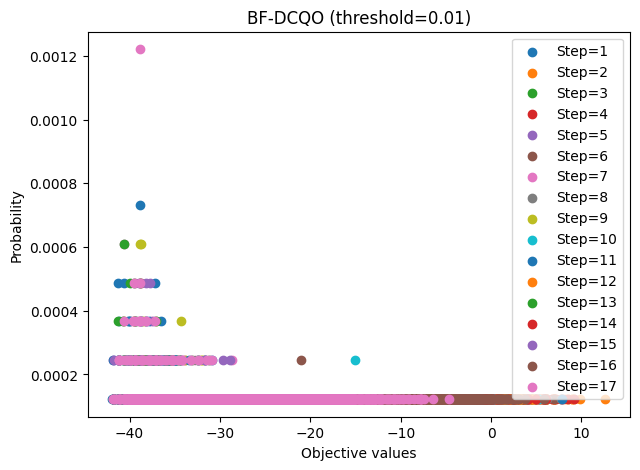

In [73]:
plt.figure(figsize=(7, 5))

plt.scatter(objective_0, pdist_0.values())
plt.scatter(objective_1, pdist_1.values())
plt.scatter(objective_2, pdist_2.values())
plt.scatter(objective_3, pdist_3.values())
plt.scatter(objective_4, pdist_4.values())
plt.scatter(objective_5, pdist_5.values())
plt.scatter(objective_6, pdist_6.values())
plt.scatter(objective_7, pdist_7.values())
plt.scatter(objective_8, pdist_8.values())
plt.scatter(objective_9, pdist_9.values())
plt.scatter(objective_10, pdist_10.values())
plt.scatter(objective_11, pdist_11.values())
plt.scatter(objective_12, pdist_12.values())
plt.scatter(objective_13, pdist_13.values())
plt.scatter(objective_14, pdist_14.values())
plt.scatter(objective_15, pdist_15.values())
plt.scatter(objective_16, pdist_16.values())

# plt.xticks(rotation=90)
plt.xlabel("Objective values")
plt.ylabel("Probability")
plt.title("BF-DCQO (threshold=0.01)")
plt.legend(
    [
        "Step=1", "Step=2", "Step=3", "Step=4", "Step=5", "Step=6", 
        "Step=7", "Step=8", "Step=9", "Step=10", "Step=11", "Step=12",
        "Step=13", "Step=14", "Step=15", "Step=16", "Step=17",
    ]
)
plt.show()

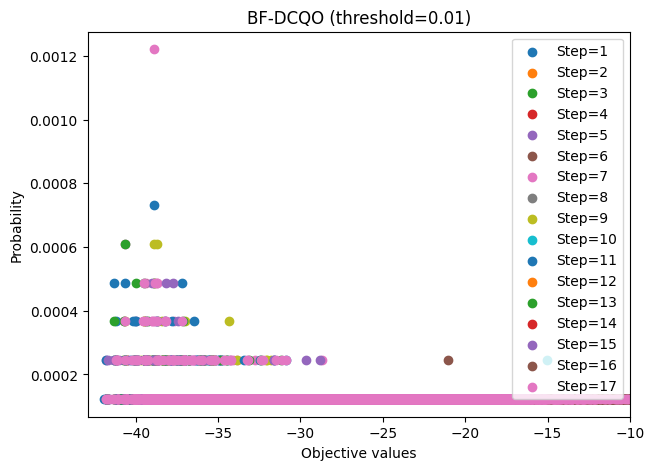

In [74]:
plt.figure(figsize=(7, 5))

plt.scatter(objective_0, pdist_0.values())
plt.scatter(objective_1, pdist_1.values())
plt.scatter(objective_2, pdist_2.values())
plt.scatter(objective_3, pdist_3.values())
plt.scatter(objective_4, pdist_4.values())
plt.scatter(objective_5, pdist_5.values())
plt.scatter(objective_6, pdist_6.values())
plt.scatter(objective_7, pdist_7.values())
plt.scatter(objective_8, pdist_8.values())
plt.scatter(objective_9, pdist_9.values())
plt.scatter(objective_10, pdist_10.values())
plt.scatter(objective_11, pdist_11.values())
plt.scatter(objective_12, pdist_12.values())
plt.scatter(objective_13, pdist_13.values())
plt.scatter(objective_14, pdist_14.values())
plt.scatter(objective_15, pdist_15.values())
plt.scatter(objective_16, pdist_16.values())

# plt.xticks(rotation=90)
plt.xlabel("Objective values")
plt.ylabel("Probability")
plt.xlim(min(objective_10) - 1.0, - 10.0)
plt.title("BF-DCQO (threshold=0.01)")
plt.legend(
    [
        "Step=1", "Step=2", "Step=3", "Step=4", "Step=5", "Step=6", 
        "Step=7", "Step=8", "Step=9", "Step=10", "Step=11", "Step=12",
        "Step=13", "Step=14", "Step=15", "Step=16", "Step=17",
    ]
)
plt.show()

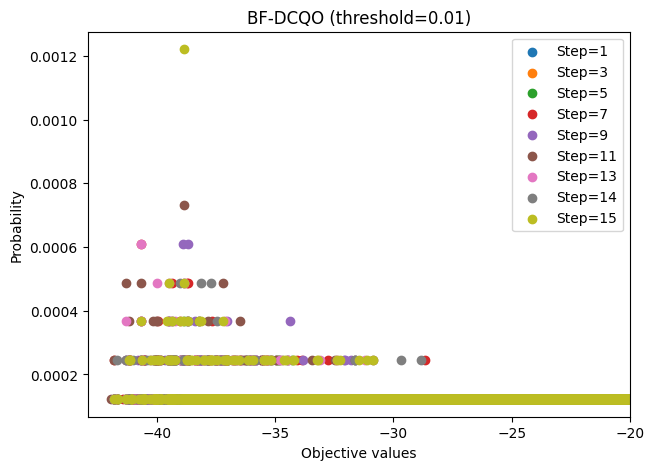

In [75]:
plt.figure(figsize=(7, 5))

plt.scatter(objective_0, pdist_0.values())
# plt.scatter(objective_1, pdist_1.values())
plt.scatter(objective_2, pdist_2.values())
# plt.scatter(objective_3, pdist_3.values())
plt.scatter(objective_4, pdist_4.values())
# plt.scatter(objective_5, pdist_5.values())
plt.scatter(objective_6, pdist_6.values())
# plt.scatter(objective_7, pdist_7.values())
plt.scatter(objective_8, pdist_8.values())
# plt.scatter(objective_9, pdist_9.values())
plt.scatter(objective_10, pdist_10.values())
# plt.scatter(objective_11, pdist_11.values())
plt.scatter(objective_12, pdist_12.values())
# plt.scatter(objective_13, pdist_13.values())
plt.scatter(objective_14, pdist_14.values())
# plt.scatter(objective_15, pdist_15.values())
plt.scatter(objective_16, pdist_16.values())

# plt.xticks(rotation=90)
plt.xlabel("Objective values")
plt.ylabel("Probability")
plt.xlim(min(objective_10) - 1.0, - 20.0)
plt.title("BF-DCQO (threshold=0.01)")
plt.legend(
    [
        "Step=1", "Step=3", "Step=5", "Step=7", "Step=9", "Step=11", 
        "Step=13", "Step=14", "Step=15", "Step=16", "Step=17",
    ]
)
plt.show()

In [76]:
print(sampled_expectation_value(pdist_0, Hf))
print(sampled_expectation_value(pdist_1, Hf))
print(sampled_expectation_value(pdist_2, Hf))
print(sampled_expectation_value(pdist_3, Hf))
print(sampled_expectation_value(pdist_4, Hf))
print(sampled_expectation_value(pdist_5, Hf))
print(sampled_expectation_value(pdist_6, Hf))
print(sampled_expectation_value(pdist_7, Hf))
print(sampled_expectation_value(pdist_8, Hf))
print(sampled_expectation_value(pdist_9, Hf))
print(sampled_expectation_value(pdist_10, Hf))
print(sampled_expectation_value(pdist_11, Hf))
print(sampled_expectation_value(pdist_12, Hf))
print(sampled_expectation_value(pdist_13, Hf))
print(sampled_expectation_value(pdist_14, Hf))
print(sampled_expectation_value(pdist_15, Hf))
print(sampled_expectation_value(pdist_16, Hf))

-24.046561991309577
-11.281647558635036
-27.744392340932446
-12.606310512393652
-28.767577914287298
-13.399335172795906
-29.17660254198392
-13.989815312288131
-28.953072625587637
-13.864358877862312
-29.115721868628974
-14.211496322238807
-28.973338316445197
-14.179027186262743
-28.7593207608834
-14.067411729486517
-28.85952442735263
